In [43]:
import sys
import sqlite3

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFECV, RFE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

In [45]:
di = 'SPI'
di_scale = 3

selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM',
]

In [46]:
df = data.filter(items=selected_columns)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')

In [47]:
selected_stations = ['Ramsar', 'Nowshahr', 'Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht', 'Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']
# selected_stations = ['Ramsar', 'Nowshahr']
# selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
# selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

start_date = '2006-09'
end_date = '2023-10'

df = df.query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

In [48]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [49]:
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')

In [50]:
cols_to_lag = [
    'ERA5_Precipitation',
    'GPM_Precipitation',
    'TRMM_Precipitation',
    'TERRACLIMATE_Precipitation',
    'PERSIANNCDR_Precipitation',
    f'GPM_{di}_{di_scale}',
    f'ERA5_{di}_{di_scale}',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM'
]

for lag in range(1, 13):
    for col in cols_to_lag:
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)

/tmp/ipykernel_178092/250578046.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)
/tmp/ipykernel_178092/250578046.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)
/tmp/ipykernel_178092/250578046.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

In [51]:
for col in cols_to_lag:
    df[f'{col}_roll_mean_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df[f'{col}_roll_std_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
    df[f'{col}_roll_mean_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
    df[f'{col}_roll_std_6'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=6, min_periods=1).std())
    df[f'{col}_roll_mean_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).mean())
    df[f'{col}_roll_std_9'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=9, min_periods=1).std())
    df[f'{col}_roll_mean_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
    df[f'{col}_roll_std_12'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=12, min_periods=1).std())


/tmp/ipykernel_178092/1487553917.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_mean_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
/tmp/ipykernel_178092/1487553917.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_std_3'] = df.groupby('Station_ID', observed=False)[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
/tmp/ipykernel_178092/1487553917.py:4: PerformanceWarning: DataFrame is highly fragmented.  Th

In [52]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y_raw = df[f'{di}_{di_scale}_Class']

# y = df[f'{di}_{di_scale}_Class']

# Stacking Meta-Model

In [53]:

# # --- 3. Data Cleaning and Splitting ---
# # --- FIX: Remove classes with only one member before splitting ---
# class_counts = y_raw.value_counts()
# classes_to_remove = class_counts[class_counts < 2].index
# if not classes_to_remove.empty:
#     print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
#     # پیدا کردن اندیس ردیف هایی که باید حذف شوند
#     indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
#     # حذف ردیف ها از X و y_raw
#     X = X.drop(indices_to_remove)
#     y_raw = y_raw.drop(indices_to_remove)
#     print(f"New data shape after removing rare classes: {X.shape}")

# # --- FIX: Encode labels *after* cleaning the data ---
# # این کار تضمین می کند که برچسب های نهایی یک دنباله پیوسته از صفر هستند
# encoder = LabelEncoder()
# y = encoder.fit_transform(y_raw)
# print("\nClass labels encoded sequentially.")


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 4. Automatic Feature Selection ---
# print("\n--- Performing Automatic Feature Selection with RFECV ---")
# estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# max_features_cap = 7

# selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=3, n_jobs=-1)
# selector_cv = selector_cv.fit(X_train, y_train)

# optimal_n_features = selector_cv.n_features_
# print(f"Optimal number of features found by RFECV: {optimal_n_features}")

# if optimal_n_features > max_features_cap:
#     print(f"Capping features to {max_features_cap}.")
#     selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
#     selector = selector.fit(X_train, y_train)
# else:
#     selector = selector_cv

# X_train_selected = selector.transform(X_train)
# X_test_selected = selector.transform(X_test)
# selected_feature_names = X_train.columns[selector.support_] # نام ستون های انتخاب شده
# print('selected_feature_names:', selected_feature_names)

# # --- 5. Data Balancing ---
# print("\nBalancing training data with SMOTE...")
# min_class_size = pd.Series(y_train).value_counts().min()
# k_neighbors = max(1, min_class_size - 1)
# smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# # استفاده از مدل های بهینه شده
# estimators = [
#     ('rf', RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1)),
#     ('cat', CatBoostClassifier(learning_rate=0.1, iterations=500, depth=6, auto_class_weights='Balanced', random_state=42, verbose=0)),
#     ('xgb', XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss', n_jobs=-1)),
#     ('svc', make_pipeline(StandardScaler(), SVC(gamma='scale', class_weight='balanced', C=10, probability=True, random_state=42))),
#     ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, n_jobs=-1))),
#     ('gnb', GaussianNB())
# ]

# # تعریف مدل نهایی برای ترکیب نتایج
# final_estimator = LogisticRegression(random_state=42, class_weight='balanced')

# stacking_model = StackingClassifier(
#     estimators=estimators,
#     final_estimator=final_estimator,
#     cv=7,
#     n_jobs=-1
# )

# print("\nTraining the final Stacking model...")
# stacking_model.fit(X_train_resampled, y_train_resampled)

# # --- 8. Prediction and Evaluation ---
# print("\n--- Evaluating the Final Model ---")
# y_pred = stacking_model.predict(X_test_selected)

# # برگرداندن برچسب های عددی به رشته ای برای گزارش
# y_test_labels = encoder.inverse_transform(y_test)
# y_pred_labels = encoder.inverse_transform(y_pred)

# accuracy = accuracy_score(y_test_labels, y_pred_labels)
# report = classification_report(y_test_labels, y_pred_labels)

# print("\n--- Final Model Evaluation Metrics (Optimized Stacking Classifier) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 9. Visualization ---
# sns.set_theme(style="whitegrid")
# cm = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix (Optimized Stacking Meta-Model)', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()


In [54]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from itertools import combinations

# # کتابخانه های مورد نیاز برای مدل های مختلف و Stacking
# from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
# from imblearn.over_sampling import SMOTE
# from sklearn.feature_selection import RFECV, RFE

# # کتابخانه های مورد نیاز برای شبکه عصبی
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.regularizers import l2


# tf.random.set_seed(42)
# np.random.seed(100)

# # --- 3. Data Cleaning, Encoding, and Splitting ---
# class_counts = y_raw.value_counts()
# classes_to_remove = class_counts[class_counts < 2].index
# if not classes_to_remove.empty:
#     print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
#     indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
#     X = X.drop(indices_to_remove)
#     y_raw = y_raw.drop(indices_to_remove)
#     print(f"New data shape after removing rare classes: {X.shape}")

# encoder = LabelEncoder()
# y = encoder.fit_transform(y_raw)
# print("\nClass labels encoded sequentially.")

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 4. Automatic Feature Selection ---
# print("\n--- Performing Automatic Feature Selection with RFECV ---")
# estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# max_features_cap = 15

# selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=5, n_jobs=-1)
# selector_cv = selector_cv.fit(X_train, y_train)

# optimal_n_features = selector_cv.n_features_
# print(f"Optimal number of features found by RFECV: {optimal_n_features}")

# if optimal_n_features > max_features_cap:
#     print(f"Capping features to {max_features_cap}.")
#     selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
#     selector = selector.fit(X_train, y_train)
# else:
#     selector = selector_cv

# X_train_selected = selector.transform(X_train)
# X_test_selected = selector.transform(X_test)

# # --- 5. Data Balancing ---
# print("\nBalancing training data with SMOTE...")
# min_class_size = pd.Series(y_train).value_counts().min()
# k_neighbors = max(1, min_class_size - 1)
# smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# # --- 6. Find the Best Combination of Base Models ---
# print("\n--- Finding the Best Combination of Base Models ---")

# # تعریف تمام مدل های پایه کاندید
# all_base_models = {
#     'rf': RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1),
#     'cat': CatBoostClassifier(learning_rate=0.1, iterations=500, depth=6, auto_class_weights='Balanced', random_state=42, verbose=0),
#     'xgb': XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss', n_jobs=-1),
#     'svc': make_pipeline(StandardScaler(), SVC(gamma='scale', class_weight='balanced', C=10, probability=True, random_state=42)),
#     'knn': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
#     'gnb': GaussianNB()
# }

# best_f1_score = -1
# best_combination = None

# # بررسی تمام ترکیب های ممکن از مدل ها
# for i in range(1, len(all_base_models) + 1):
#     for combo in combinations(all_base_models.items(), i):
#         combo_names = [name for name, model in combo]
#         print(f"Testing combination: {combo_names}")
        
#         # ساخت ویژگی های متا برای ترکیب فعلی
#         meta_features_list = []
#         for name, model in combo:
#             model.fit(X_train_resampled, y_train_resampled)
#             preds = model.predict_proba(X_test_selected)
#             meta_features_list.append(preds)
        
#         meta_X = np.concatenate(meta_features_list, axis=1)

#         # آموزش یک مدل نهایی ساده برای ارزیابی سریع ترکیب
#         final_model = LogisticRegression(random_state=42, class_weight='balanced')
#         final_model.fit(meta_X, y_test) # Note: Fitting on test meta-features for quick evaluation
#         y_pred_combo = final_model.predict(meta_X)
        
#         # محاسبه امتیاز f1_macro
#         score = f1_score(y_test, y_pred_combo, average='macro')
        
#         if score > best_f1_score:
#             best_f1_score = score
#             best_combination = combo
#             print(f"New best combination found: {combo_names} with F1-score: {score:.4f}")

# best_model_names = [name for name, model in best_combination]
# print(f"\n--- Best combination of models selected: {best_model_names} ---")

# # --- 7. Train Final Ensemble with the Best Combination ---
# print("\n--- Training Final Ensemble with Best Models ---")
# best_base_models = dict(best_combination)

# meta_X_train_list = []
# meta_X_test_list = []

# for name, model in best_base_models.items():
#     print(f"Re-training {name} on full resampled data...")
#     model.fit(X_train_resampled, y_train_resampled)
#     train_preds = model.predict_proba(X_train_resampled)
#     test_preds = model.predict_proba(X_test_selected)
#     meta_X_train_list.append(train_preds)
#     meta_X_test_list.append(test_preds)

# meta_X_train = np.concatenate(meta_X_train_list, axis=1)
# meta_X_test = np.concatenate(meta_X_test_list, axis=1)

# # --- 8. Build, Compile, and Train the Neural Network Meta-Model ---
# print("\n--- Building and Training the Neural Network Meta-Model ---")
# n_classes = len(encoder.classes_)

# nn_model = Sequential([
#     Dense(64, input_dim=meta_X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.5),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.5),
#     Dense(n_classes, activation='softmax')
# ])

# nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# nn_model.summary()

# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# history = nn_model.fit(
#     meta_X_train, y_train_resampled,
#     epochs=200, batch_size=32,
#     validation_split=0.2,
#     callbacks=[early_stopping], verbose=1
# )

# # --- 9. Prediction and Evaluation ---
# print("\n--- Evaluating the Final Neural Network Model ---")
# y_pred_probs = nn_model.predict(meta_X_test)
# y_pred = np.argmax(y_pred_probs, axis=1)

# y_test_labels = encoder.inverse_transform(y_test)
# y_pred_labels = encoder.inverse_transform(y_pred)

# accuracy = accuracy_score(y_test_labels, y_pred_labels)
# report = classification_report(y_test_labels, y_pred_labels)

# print("\n--- Final Model Evaluation Metrics (Neural Network Ensemble) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 10. Visualization ---
# sns.set_theme(style="whitegrid")

# # الف) نمودار دقت و خطا
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # ب) ماتریس درهم ریختگی آزمون
# cm_test = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix (Test Set)', fontsize=16)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # ج) ماتریس درهم ریختگی آموزش
# print("\n--- Visualizing Training Set Performance ---")
# y_train_pred_probs = nn_model.predict(meta_X_train)
# y_train_pred = np.argmax(y_train_pred_probs, axis=1)
# y_train_labels = encoder.inverse_transform(y_train_resampled)
# y_train_pred_labels = encoder.inverse_transform(y_train_pred)
# cm_train = confusion_matrix(y_train_labels, y_train_pred_labels, labels=encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix (Training Set)', fontsize=16)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()




In [55]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from itertools import combinations

# # کتابخانه های مورد نیاز برای مدل های مختلف و Stacking
# from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, ExtraTreesClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# # مدل های جدید اضافه شدند
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
# from imblearn.over_sampling import SMOTE
# from sklearn.feature_selection import RFECV, RFE

# # کتابخانه های مورد نیاز برای شبکه عصبی
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.regularizers import l2

# # برای اطمینان از تکرارپذیری نتایج
# tf.random.set_seed(100)
# np.random.seed(42)


# # --- 3. Data Cleaning, Encoding, and Splitting ---
# class_counts = y_raw.value_counts()
# classes_to_remove = class_counts[class_counts < 2].index
# if not classes_to_remove.empty:
#     print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
#     indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
#     X = X.drop(indices_to_remove)
#     y_raw = y_raw.drop(indices_to_remove)
#     print(f"New data shape after removing rare classes: {X.shape}")

# encoder = LabelEncoder()
# y = encoder.fit_transform(y_raw)
# print("\nClass labels encoded sequentially.")

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 4. Automatic Feature Selection ---
# print("\n--- Performing Automatic Feature Selection with RFECV ---")
# estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# max_features_cap = 10

# selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=3, n_jobs=-1)
# selector_cv = selector_cv.fit(X_train, y_train)

# optimal_n_features = selector_cv.n_features_
# print(f"Optimal number of features found by RFECV: {optimal_n_features}")

# if optimal_n_features > max_features_cap:
#     print(f"Capping features to {max_features_cap}.")
#     selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
#     selector = selector.fit(X_train, y_train)
# else:
#     selector = selector_cv

# X_train_selected = selector.transform(X_train)
# X_test_selected = selector.transform(X_test)

# # --- 5. Data Balancing ---
# print("\nBalancing training data with SMOTE...")
# min_class_size = pd.Series(y_train).value_counts().min()
# k_neighbors = max(1, min_class_size - 1)
# smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# # --- 6. Find the Best Combination of Base and Final Models ---
# print("\n--- Finding the Best Combination of Models ---")

# # تعریف تمام مدل های پایه کاندید
# all_base_models = {
#     # 'rf': RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1),
#     'cat': CatBoostClassifier(learning_rate=0.1, iterations=500, depth=6, auto_class_weights='Balanced', random_state=42, verbose=0),
#     'xgb': XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss', n_jobs=-1),
#     'svc': make_pipeline(StandardScaler(), SVC(gamma='scale', class_weight='balanced', C=10, probability=True, random_state=42)),
#     'knn': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
#     'gnb': GaussianNB(),
#     'lda': LinearDiscriminantAnalysis(),
#     'qda': QuadraticDiscriminantAnalysis(),
#     'ada': AdaBoostClassifier(random_state=42),
#     'et': ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
# }

# # تعریف مدل های نهایی کاندید برای ارزیابی سریع
# quick_eval_final_models = {
#     'lr': LogisticRegression(random_state=42, class_weight='balanced'),
#     'rf_final': RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1)
# }

# best_f1_score = -1
# best_combination = None
# best_final_model_name = None

# # آموزش تمام مدل های پایه یک بار
# trained_base_models = {}
# for name, model in all_base_models.items():
#     print(f"Pre-training {name}...")
#     model.fit(X_train_resampled, y_train_resampled)
#     trained_base_models[name] = model

# # بررسی تمام ترکیب های ممکن از مدل ها
# for i in range(1, len(all_base_models) + 1):
#     for combo in combinations(all_base_models.keys(), i):
#         # ساخت ویژگی های متا برای ترکیب فعلی
#         meta_features_list = [trained_base_models[name].predict_proba(X_test_selected) for name in combo]
#         meta_X = np.concatenate(meta_features_list, axis=1)
        
#         # ارزیابی با هر مدل نهایی کاندید
#         for final_name, final_model in quick_eval_final_models.items():
#             final_model.fit(meta_X, y_test)
#             y_pred_combo = final_model.predict(meta_X)
#             score = f1_score(y_test, y_pred_combo, average='macro')
            
#             if score >= best_f1_score:
#                 best_f1_score = score
#                 best_combination = combo
#                 best_final_model_name = final_name
#                 print(f"New best combination found: {list(combo)} with final model '{final_name}' -> F1-score: {score:.4f}")

# print(f"\n--- Best combination of models selected: {list(best_combination)} ---")
# print(f"--- Best final model for quick evaluation: {best_final_model_name} ---")


# # --- 7. Train Final Ensemble with the Best Combination ---
# print("\n--- Training Final Ensemble with Best Models ---")
# best_base_models = {name: all_base_models[name] for name in best_combination}

# meta_X_train_list = []
# meta_X_test_list = []

# for name, model in best_base_models.items():
#     print(f"Re-training {name} on full resampled data...")
#     model.fit(X_train_resampled, y_train_resampled)
#     train_preds = model.predict_proba(X_train_resampled)
#     test_preds = model.predict_proba(X_test_selected)
#     meta_X_train_list.append(train_preds)
#     meta_X_test_list.append(test_preds)

# meta_X_train = np.concatenate(meta_X_train_list, axis=1)
# meta_X_test = np.concatenate(meta_X_test_list, axis=1)

# # --- 8. Build, Compile, and Train the Neural Network Meta-Model ---
# print("\n--- Building and Training the Neural Network Meta-Model ---")
# n_classes = len(encoder.classes_)

# nn_model = Sequential([
#     Dense(64, input_dim=meta_X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.5),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.5),
#     Dense(n_classes, activation='softmax')
# ])

# nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# nn_model.summary()

# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# history = nn_model.fit(
#     meta_X_train, y_train_resampled,
#     epochs=150, batch_size=32,
#     validation_split=0.2,
#     callbacks=[early_stopping], verbose=1
# )

# # --- 8. Prediction and Evaluation ---
# print("\n--- Evaluating the Final Neural Network Model ---")
# y_pred_probs = nn_model.predict(meta_X_test)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # برگرداندن برچسب های عددی به رشته ای برای گزارش
# y_test_labels = encoder.inverse_transform(y_test)
# y_pred_labels = encoder.inverse_transform(y_pred)

# accuracy = accuracy_score(y_test_labels, y_pred_labels)
# report = classification_report(y_test_labels, y_pred_labels)

# print("\n--- Final Model Evaluation Metrics (Neural Network Ensemble) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report (Test Set):")
# print(report)

# # --- 9. Visualization ---
# sns.set_theme(style="whitegrid")

# # الف) نمودار دقت و خطا در طول آموزش
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.tight_layout()
# plt.show()


# # ب) ماتریس درهم ریختگی برای داده های آزمون
# cm_test = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix (Test Set)', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()

# # --- 10. (NEW) Visualization and Report for Training Set ---
# print("\n--- Evaluating and Visualizing Training Set Performance ---")

# # پیش بینی روی داده های آموزشی برای مقایسه
# y_train_pred_probs = nn_model.predict(meta_X_train)
# y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# # برگرداندن برچسب های عددی به رشته ای برای گزارش
# y_train_labels = encoder.inverse_transform(y_train_resampled)
# y_train_pred_labels = encoder.inverse_transform(y_train_pred)

# # (NEW) چاپ گزارش طبقه‌بندی برای داده های آموزشی
# print("\nClassification Report (Training Set):")
# report_train = classification_report(y_train_labels, y_train_pred_labels)
# print(report_train)

# # ج) ماتریس درهم ریختگی برای داده های آموزشی
# cm_train = confusion_matrix(y_train_labels, y_train_pred_labels, labels=encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix (Training Set)', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()



Class labels encoded sequentially.

--- Scaling Data ---

--- Performing Automatic Feature Selection with RFECV ---
Optimal number of features found by RFECV: 10
RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                       random_state=42),
      min_features_to_select=5, n_jobs=-1, scoring='f1_macro')
Final selected features: ['GPM_SPI_3', 'ERA5_SPI_3', 'CI_GPM', 'TRMM_Precipitation_lag_6', 'LSTNight_lag_6', 'GPM_Precipitation_roll_mean_3', 'GPM_SPI_3_roll_mean_3', 'PCI_GPM_roll_mean_3', 'PCI_GPM_roll_mean_9', 'PCI_GPM_roll_std_9']

Balancing training data with SMOTE...

--- Training Base Models to Create Meta-Features ---
Training rf...
Training cat...
Training xgb...
Training svc...
Training knn...
Training gnb...
Meta-features created. Train shape: (8547, 42), Test shape: (438, 42)

--- Building and Training the Neural Network Meta-Model ---


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │         2,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,063 (19.78 KB)

 Trainable params: 5,063 (19.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7288 - loss: 0.8728 - val_accuracy: 0.3678 - val_loss: 1.4330
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9422 - loss: 0.2114 - val_accuracy: 0.8211 - val_loss: 0.9606
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9652 - loss: 0.1232 - val_accuracy: 0.8836 - val_loss: 0.6144
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9724 - loss: 0.0908 - val_accuracy: 0.9170 - val_loss: 0.4199
Epoch 5/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9810 - loss: 0.0645 - val_accuracy: 0.9485 - val_loss: 0.2635
Epoch 6/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9852 - loss: 0.0576 - val_accuracy: 0.9468 - val_loss: 0.2185
Epoch 7/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9855 - loss: 0.0496 - val_accuracy: 0.9509 - val_loss: 0.1986
Epoch 8/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9890 - loss: 0.0401 - val_accu

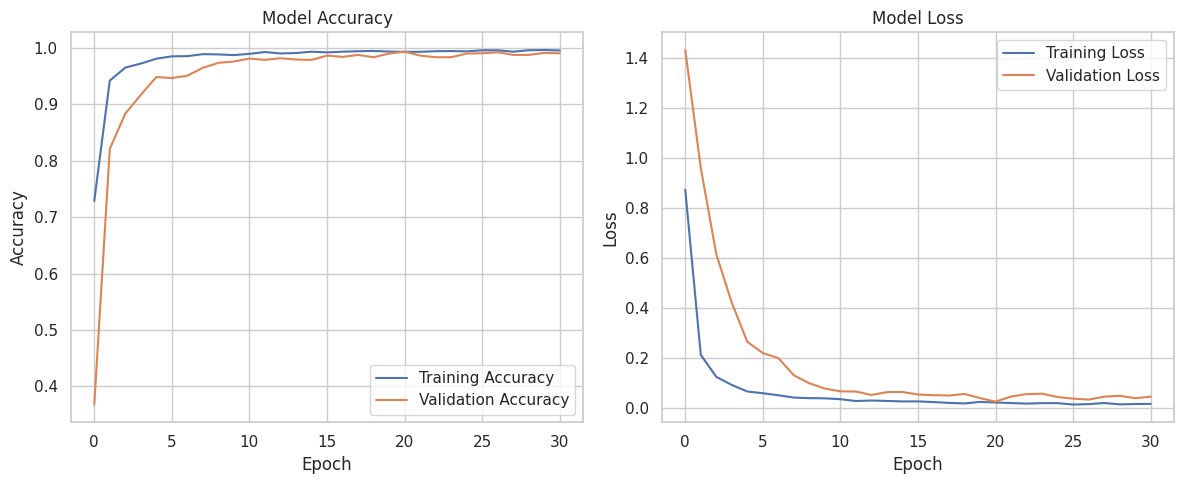

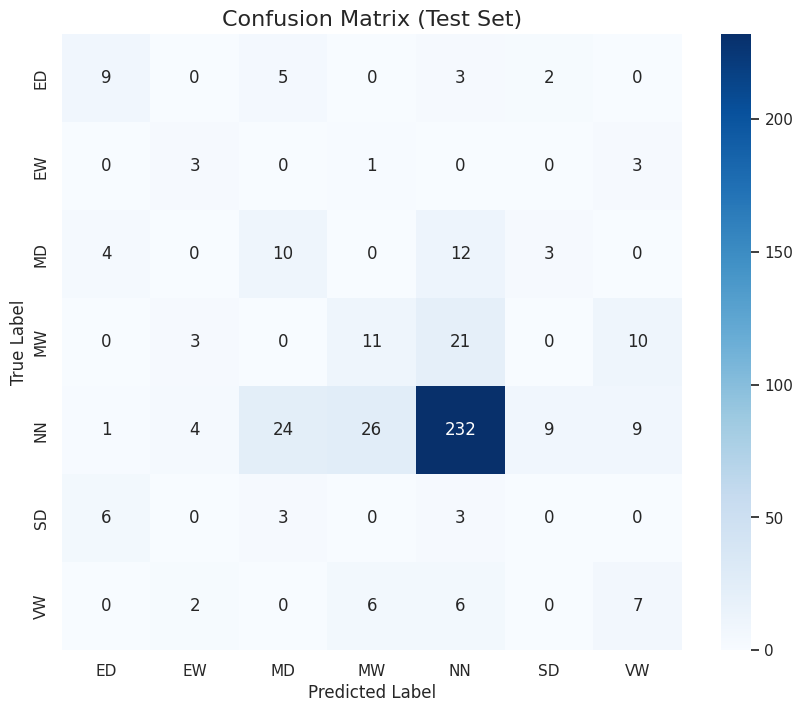


--- Evaluating and Visualizing Training Set Performance ---
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report (Training Set):
              precision    recall  f1-score   support

          ED       1.00      1.00      1.00      1221
          EW       1.00      1.00      1.00      1221
          MD       1.00      1.00      1.00      1221
          MW       1.00      1.00      1.00      1221
          NN       1.00      1.00      1.00      1221
          SD       1.00      1.00      1.00      1221
          VW       1.00      0.99      1.00      1221

    accuracy                           1.00      8547
   macro avg       1.00      1.00      1.00      8547
weighted avg       1.00      1.00      1.00      8547



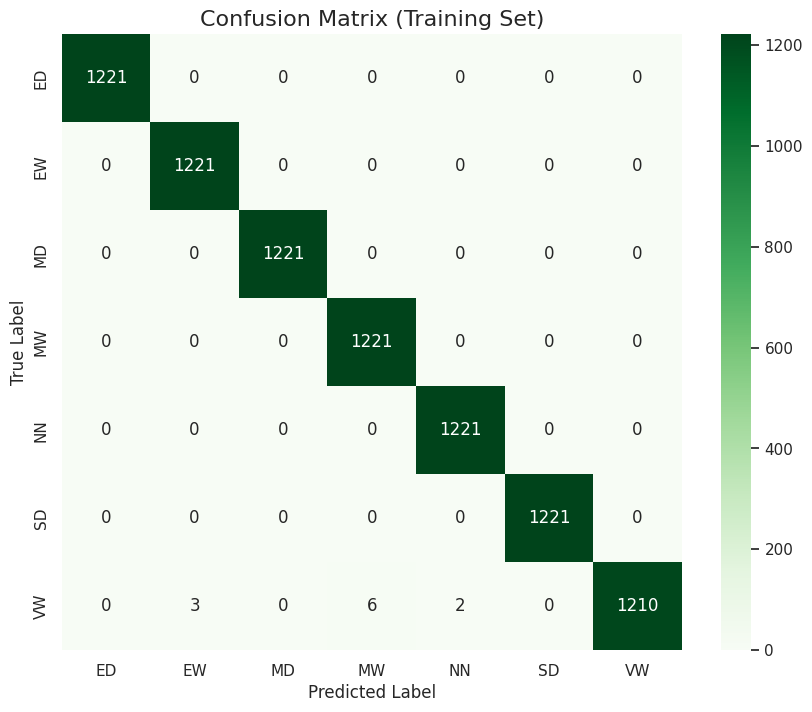

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# کتابخانه های مورد نیاز برای مدل های مختلف و Stacking
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
# StandardScaler برای استانداردسازی داده ها اضافه شد
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, RFE

# کتابخانه های مورد نیاز برای شبکه عصبی
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2


# برای اطمینان از تکرارپذیری نتایج
tf.random.set_seed(42)
np.random.seed(42)


# --- 3. Data Cleaning, Encoding, and Splitting ---
class_counts = y_raw.value_counts()
classes_to_remove = class_counts[class_counts < 2].index
if not classes_to_remove.empty:
    print(f"\nRemoving classes with fewer than 2 samples: {list(classes_to_remove)}")
    indices_to_remove = y_raw[y_raw.isin(classes_to_remove)].index
    X = X.drop(indices_to_remove)
    y_raw = y_raw.drop(indices_to_remove)
    print(f"New data shape after removing rare classes: {X.shape}")

encoder = LabelEncoder()
y = encoder.fit_transform(y_raw)
print("\nClass labels encoded sequentially.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# --- 4. Data Scaling ---
print("\n--- Scaling Data ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 5. Automatic Feature Selection ---
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
max_features_cap = 20

selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=5, n_jobs=-1)
# انتخاب ویژگی روی داده های مقیاس شده انجام می شود
selector_cv = selector_cv.fit(X_train_scaled, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")
print(selector_cv)

if optimal_n_features > max_features_cap:
    print(f"Capping features to {max_features_cap}.")
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train_scaled, y_train)
else:
    selector = selector_cv

X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)


# این خط نام ستون‌های انتخاب شده را استخراج می‌کند
selected_features = X_train.columns[selector.support_]

# این خط نام‌ها را در خروجی چاپ می‌کند
print("Final selected features:", list(selected_features))

# --- 6. Data Balancing ---
print("\nBalancing training data with SMOTE...")
min_class_size = pd.Series(y_train).value_counts().min()
k_neighbors = max(1, min_class_size - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# --- 7. Train Base Models and Create Meta-Features ---
print("\n--- Training Base Models to Create Meta-Features ---")

# تعریف مدل های پایه (Pipeline ها برای SVC و KNN حذف شدند)
base_models = {
    'rf': RandomForestClassifier(n_estimators=400, min_samples_split=5, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1),
    'cat': CatBoostClassifier(learning_rate=0.1, iterations=500, depth=6, auto_class_weights='Balanced', random_state=42, verbose=0),
    'xgb': XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, random_state=42, eval_metric='mlogloss', n_jobs=-1),
    'svc': SVC(gamma='scale', class_weight='balanced', C=10, probability=True, random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'gnb': GaussianNB()
}

# آموزش مدل های پایه و گرفتن پیش بینی های آنها به عنوان ویژگی های جدید
meta_X_train_list = []
meta_X_test_list = []

for name, model in base_models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    # گرفتن پیش بینی های احتمالاتی به عنوان ویژگی
    train_preds = model.predict_proba(X_train_resampled)
    test_preds = model.predict_proba(X_test_selected)
    meta_X_train_list.append(train_preds)
    meta_X_test_list.append(test_preds)

# ترکیب پیش بینی ها برای ساخت دیتاست متا
meta_X_train = np.concatenate(meta_X_train_list, axis=1)
meta_X_test = np.concatenate(meta_X_test_list, axis=1)
print(f"Meta-features created. Train shape: {meta_X_train.shape}, Test shape: {meta_X_test.shape}")


# --- 8. Build, Compile, and Train the Neural Network Meta-Model ---
print("\n--- Building and Training the Neural Network Meta-Model ---")

n_classes = len(encoder.classes_)

# ساخت مدل Sequential
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=meta_X_train.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(n_classes, activation='softmax'))

# کامپایل کردن مدل
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.summary()

# آموزش مدل
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = nn_model.fit(
    meta_X_train,
    y_train_resampled,
    epochs=100,
    batch_size=32,
    validation_split=0.2, # استفاده از بخشی از داده های آموزشی برای اعتبارسنجی
    callbacks=[early_stopping],
    verbose=1
)

# --- 9. Prediction and Evaluation ---
print("\n--- Evaluating the Final Neural Network Model ---")
y_pred_probs = nn_model.predict(meta_X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# برگرداندن برچسب های عددی به رشته ای برای گزارش
y_test_labels = encoder.inverse_transform(y_test)
y_pred_labels = encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
report = classification_report(y_test_labels, y_pred_labels)

print("\n--- Final Model Evaluation Metrics (Neural Network Ensemble) ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(report)

# --- 10. Visualization ---
sns.set_theme(style="whitegrid")

# الف) نمودار دقت و خطا در طول آموزش
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# ب) ماتریس درهم ریختگی برای داده های آزمون
cm_test = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# --- 11. Visualization and Report for Training Set ---
print("\n--- Evaluating and Visualizing Training Set Performance ---")

# پیش بینی روی داده های آموزشی برای مقایسه
y_train_pred_probs = nn_model.predict(meta_X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# برگرداندن برچسب های عددی به رشته ای برای گزارش
y_train_labels = encoder.inverse_transform(y_train_resampled)
y_train_pred_labels = encoder.inverse_transform(y_train_pred)

# چاپ گزارش طبقه‌بندی برای داده های آموزشی
print("\nClassification Report (Training Set):")
report_train = classification_report(y_train_labels, y_train_pred_labels)
print(report_train)

# ج) ماتریس درهم ریختگی برای داده های آموزشی
cm_train = confusion_matrix(y_train_labels, y_train_pred_labels, labels=encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Training Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()